In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
import xgboost as xgb
import seaborn as sns
import pickle

# Data Preparation

In [13]:
csv_file_path = 'data/nba_games_team_level.csv'
df = pd.read_csv(csv_file_path)
df.head()

,team_abbreviation_home,team_abbreviation_away,off_eff_fg_perc,def_eff_fg_perc,off_tov_perc,def_tov_perc,off_reb_perc,def_reb_perc,off_free_throw_factor,def_free_throw_factor,game_date,outcome
0,CHA,CLE,0.575000,0.511494,0.174825,0.089318,0.194444,0.765957,0.200000,0.287356,2023-03-12 00:00:00,0.0
1,PHI,WAS,0.581250,0.440476,0.090799,0.096043,0.236842,0.846154,0.237500,0.226190,2023-03-12 00:00:00,1.0
2,SAS,OKC,0.431818,0.431579,0.164702,0.078864,0.188679,0.769231,0.159091,0.210526,2023-03-12 00:00:00,0.0
3,NOP,POR,0.610465,0.545455,0.131857,0.164076,0.181818,0.777778,0.255814,0.159091,2023-03-12 00:00:00,1.0
4,LAL,NYK,0.550562,0.539773,0.102345,0.101626,0.227273,0.692308,0.112360,0.193182,2023-03-12 00:00:00,0.0


In [14]:
# Filter out rows with NaN values
filtered_df = df.dropna(axis=0)

# Calculate the number of removed rows
num_removed_columns = df.shape[0] - filtered_df.shape[0]

# Print the total number of removed rows
print("Total number of removed columns:", num_removed_columns)

# define the columns to drop
target_column = 'outcome'
columns_to_drop = ['team_abbreviation_home', 'team_abbreviation_away', 'game_date']

# Separate the predictors and target variable in the train set
filtered_df = filtered_df.drop(columns=columns_to_drop)

# Split the data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Split the train set into train and validation sets (75% train, 25% validation)
train_data, validation_data = train_test_split(train_data, test_size=0.25, random_state=42)

# Print the shapes of the resulting sets
print("Train set observations:        ", train_data.shape[0])
print("Validation set observations:   ", validation_data.shape[0])
print("Test set observations:         ", test_data.shape[0])

Total number of removed columns: 7
Train set observations:         23995
Validation set observations:    7999
Test set observations:          7999


![title](imgs/data_split.png)

In [15]:
# Separate the predictors and target variable in the train set
X_train = train_data.drop(target_column, axis=1)  # Drop the target column
y_train = train_data[target_column]  # Select only the target column

# Separate the predictors and target variable in the test set
X_val = validation_data.drop(target_column, axis=1)
y_val = validation_data[target_column]

# Separate the predictors and target variable in the test set
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

# Classic Logistical Regression

In [23]:
# Initialize the logistic regression model
logreg = LogisticRegression()

# Set the desired parameters
logreg.penalty = 'l2'  # Regularization penalty ('l1' or 'l2')
logreg.C = 0.6  # Inverse of regularization strength (smaller values specify stronger regularization)
logreg.solver = 'liblinear'  # Algorithm to use for optimization (e.g., 'liblinear', 'newton-cg', 'lbfgs')
logreg.max_iter = 100  # Maximum number of iterations for the solver to converge
logreg.random_state = 42  # Seed for random number generation (for reproducibility)

# Train the model on the training data
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9422427803475435


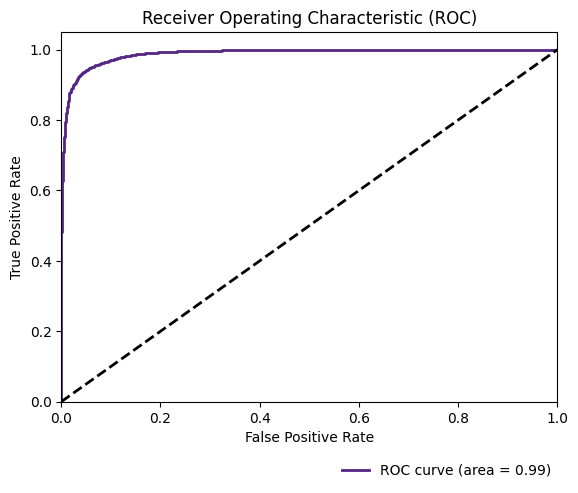

In [22]:
# Get the predicted probabilities for the positive class
y_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="#552583", lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right", bbox_to_anchor=(1.0, -0.22), borderaxespad=0, facecolor='none',frameon=False)

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/logreg_ROC.png', transparent=True, dpi=300,bbox_inches='tight')
plt.show()

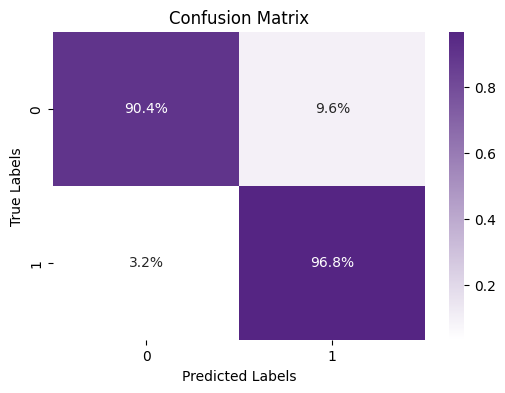

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) 

# Define custom color gradient
colors = ["#FFFFFF", "#552583"]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap=cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/logreg_confusion_matrix.png', transparent=True, dpi=300)

plt.show()

## Cross Validation

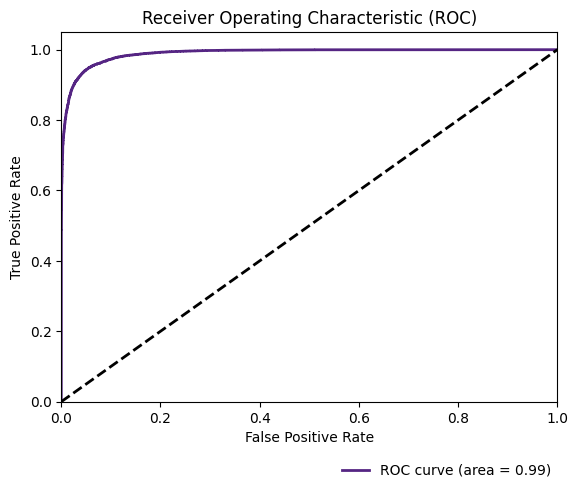

Cross-validated AUC scores: [0.98421881 0.98136384 0.98504966 0.98346113 0.98434238]
Mean AUC score: 0.9836871629301444


In [21]:
# Separate the predictors and target variable in the train set
X_train = train_data.drop(target_column, axis=1)  # Drop the target column
y_train = train_data[target_column]  # Select only the target column

# Separate the predictors and target variable in the test set
X_test = test_data.drop(target_column, axis=1)
y_test = test_data[target_column]

# Initialize the logistic regression model
cv_logreg = LogisticRegression()

# Perform cross-validation and get predicted probabilities
y_prob_cv = cross_val_predict(cv_logreg, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate the false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr,lw=2, label='ROC curve (area = %0.2f)' % roc_auc,color='#552583')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right", bbox_to_anchor=(1.0, -0.22), borderaxespad=0, facecolor='none',frameon=False)

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/cv_logreg_ROC.png', transparent=True, dpi=300,bbox_inches='tight')
plt.show()

# Calculate the AUC score using cross-validatioqn
auc_scores = cross_val_score(cv_logreg, X_test, y_test, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", auc_scores)
print("Mean AUC score:", auc_scores.mean())

## Save Model

In [24]:
model_path = "models/logreg_game_outcome_v2.pkl"

# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(logreg, file)

## Import Model and Inference

In [25]:
model_path = "models/logreg_game_outcome_v2.pkl"

# Load the model from the pickle file
with open(model_path, 'rb') as file:
    model = pickle.load(file)

# Perform inference/predictions using the loaded model

predictions = model.predict(X_test)

predictions


array([1., 0., 0., ..., 0., 1., 1.])

# Decision Tree

### Simple Tree

Accuracy: 0.8294786848356045


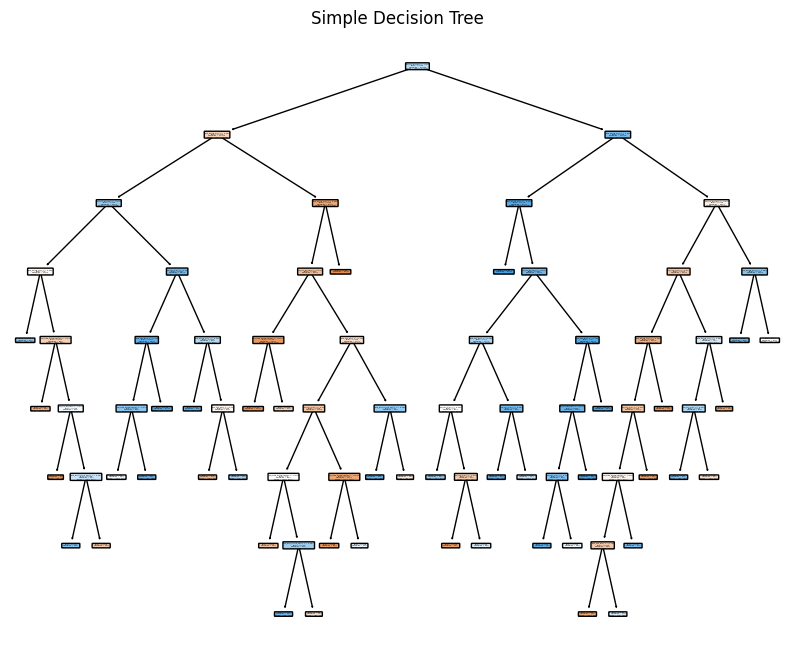

In [27]:
# Define and set the parameters for the decision tree
tree_params = {
    'criterion': 'gini',       # The function to measure the quality of a split (gini or entropy)
    'max_depth': 10,         # The maximum depth of the tree (None means unlimited depth)
    'min_samples_split': 10,    # The minimum number of samples required to split an internal node
    'min_samples_leaf': 2,     # The minimum number of samples required to be at a leaf node
    'max_features': None,
    'ccp_alpha': 0.001,      # The number of features to consider when looking for the best split (None means all features)
}

# Create a Decision Tree Regressor object
dtree = DecisionTreeClassifier(**tree_params)

# Train the model
dtree.fit(X_train, y_train)

# Evaluate the best model on the test set
accuracy = dtree.score(X_test, y_test)
print("Accuracy:", accuracy)

# Visualize the decision tree
plt.figure(figsize=(10, 8))
plot_tree(dtree, filled=True, rounded=True, feature_names=X_train.columns)
plt.title('Simple Decision Tree')
plt.show()

### Grid Search

Best Model Accuracy: 0.838104763095387


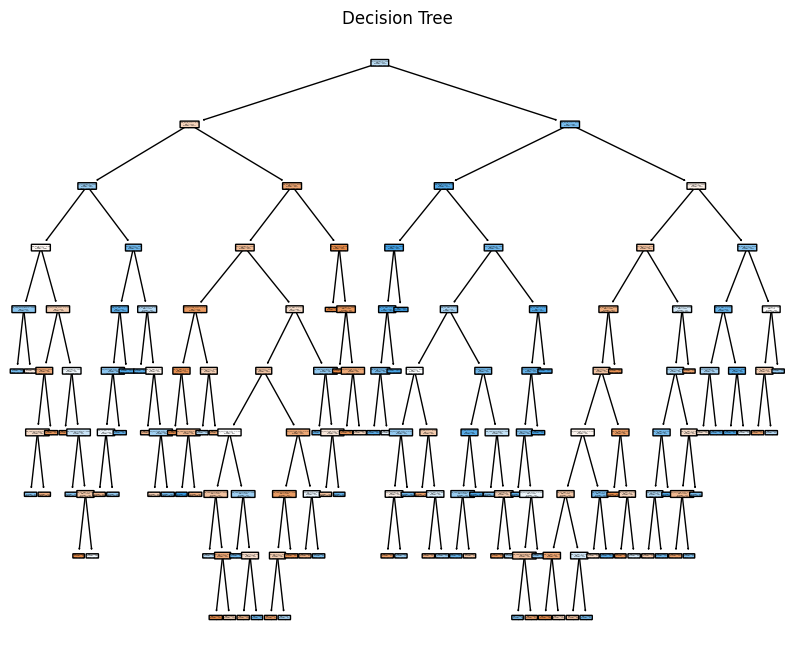

{'ccp_alpha': 0.0005, 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [28]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [5, 50, 100, 200],
    'min_samples_leaf': [5, 15, 30, 50],
    'ccp_alpha': [0.01, 0.006, 0.003, 0.001, 0.0005]
}

# Create an classifier
dtree = DecisionTreeClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(dtree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values and the corresponding model
best_params = grid_search.best_params_
best_dtree = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_dtree.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)

# Visualize the decision tree
plt.figure(figsize=(10, 8))
plot_tree(best_dtree, filled=True, rounded=True, feature_names=X_train.columns)
plt.title('Decision Tree')
plt.show()

print(best_params)

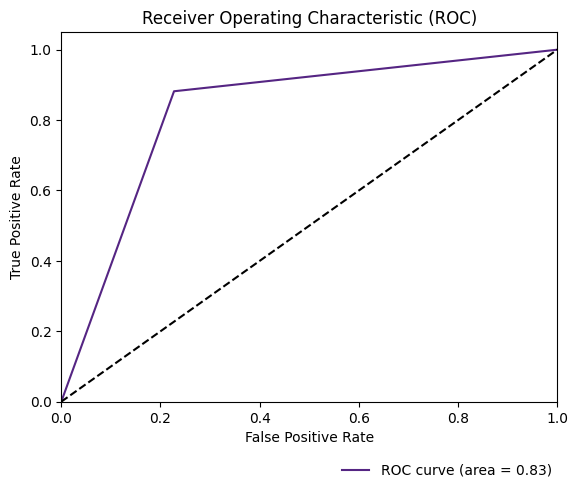

In [29]:
# Perform predictions on the best tree and the test set
y_pred = best_dtree.predict(X_test)

# Calculate the false positive rate and true positive rate for ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color='#552583')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right", bbox_to_anchor=(1.0, -0.22), borderaxespad=0, facecolor='none',frameon=False)

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/grid_search_dtree_ROC.png', transparent=True, dpi=300,bbox_inches='tight')

plt.show()

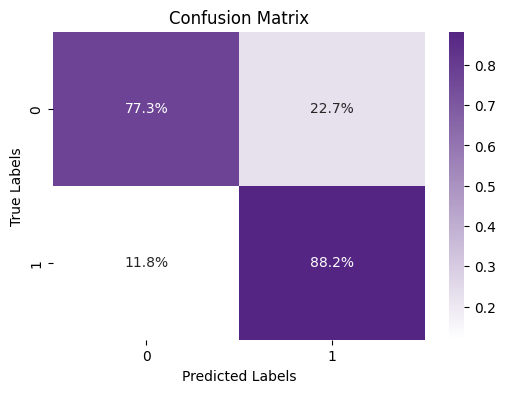

In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1)

# Define custom color gradient
colors = ["#FFFFFF", "#552583"]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap=cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/grid_search_dtree_confusion_matrix.png', transparent=True, dpi=300)

plt.show()

### Save Decision Tree

In [31]:
model_path = "models/dtree_game_outcome_v1.pkl"

# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(best_dtree, file)

# XGBOOST

In [33]:
# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

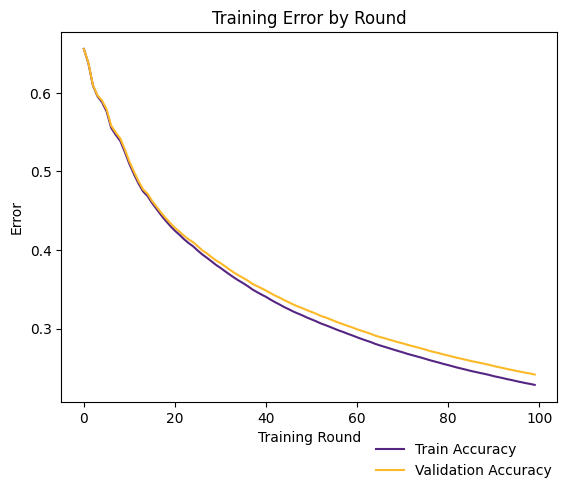

In [40]:
# Set the XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Assuming binary classification
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

xgbcl = xgb.XGBClassifier(**params)

xgbcl.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #eval_metric='logloss',
        verbose=False)

evals_result = xgbcl.evals_result()

# List of error values for each training round
train_error = evals_result['validation_0']['logloss']
val_error = evals_result['validation_1']['logloss']

# Generate the x-axis values representing the training rounds
rounds = range(1, 100)

plt.plot(train_error, label='Train Accuracy', color='#552583')
plt.plot(val_error, label='Validation Accuracy', color='#FDB927')
plt.xlabel('Training Round')
plt.ylabel('Error')
plt.title('Training Error by Round')

plt.legend(loc="lower right", bbox_to_anchor=(1.0, -0.22), borderaxespad=0, facecolor='none',frameon=False)

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/xgb_train_error.png', transparent=True, dpi=300,bbox_inches='tight')

plt.show()

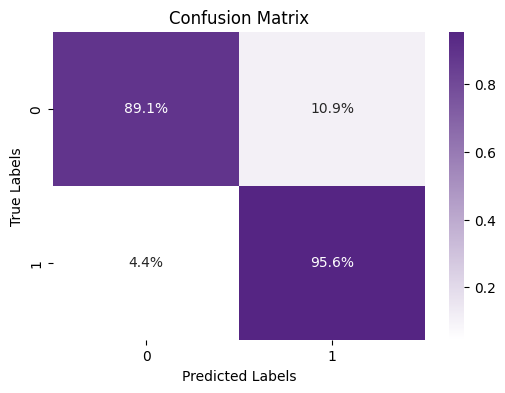

In [41]:
y_pred = xgbcl.predict(X_test)

# Convert probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Define custom color gradient
colors = ["#FFFFFF", "#552583"]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors)

# Calculate percentages
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) 

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt=".1%", cmap=cmap)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/xgb_confusion_matrix.png', transparent=True, dpi=300)

plt.show()

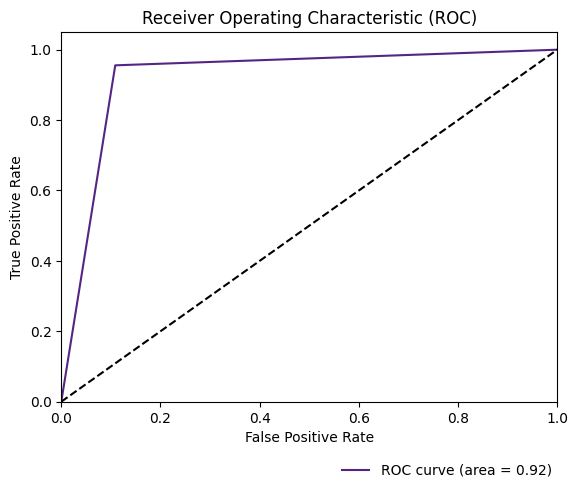

In [42]:
# Calculate the false positive rate and true positive rate for ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color="#552583")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')

plt.legend(loc="lower right", bbox_to_anchor=(1.0, -0.22), borderaxespad=0, facecolor='none',frameon=False)

# Set the background color to transparent
plt.gca().set_facecolor('none')

# Save the image with a transparent background
plt.savefig('graphs/xgb_ROC.png', transparent=True, dpi=300,bbox_inches='tight')


plt.show()

### Xgboost Cross-Validation

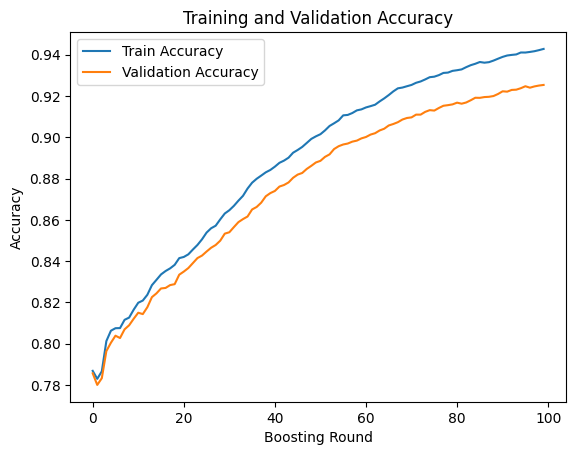

In [38]:
# Perform cross-validation to obtain the evaluation results
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=3, stratified=True, metrics='error', early_stopping_rounds=10)

# Extract the training and validation error values
train_error = cv_results['train-error-mean']
val_error = cv_results['test-error-mean']

# Convert error values to accuracy values
train_acc = [1 - err for err in train_error]
val_acc = [1 - err for err in val_error]

# Plot the training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Boosting Round')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [39]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
}

clf = xgb.XGBClassifier()
# Create an XGBoost classifier
clf = xgb.XGBClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameter values and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model.score(X_test, y_test)
print("Best Model Accuracy:", accuracy)

Best Model Accuracy: 0.9528691086385799


### Save XGB

In [44]:
model_path = "models/xgbcl_game_outcome_v1.pkl"

# Save the model to a file
with open(model_path, 'wb') as file:
    pickle.dump(xgbcl, file)

# Exaplanation

## Logistic Regression

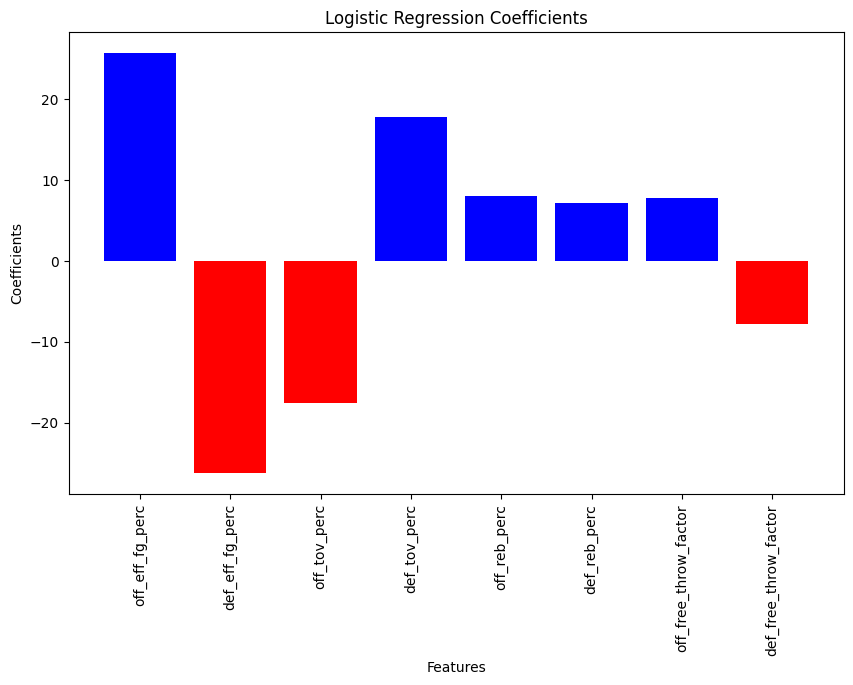

In [49]:
coefficients = model.coef_[0]
feature_names = X_train.columns  # Assuming your DataFrame is named 'df'
#feature_names = feature_names[2:10]

# Determine color based on coefficient sign and magnitude
colors = ['blue' if c > 0 else 'red' for c in coefficients]

# Plotting the coefficients as a bar chart with a blue-to-red gradient
plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients, color=colors)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Coefficients")
plt.show()

## XGboost

In [76]:
import shap

# Assuming you have your XGBoost classifier named 'clf' and your test data named 'X_test'

# Define a function to return predicted probabilities
def predict_proba(data):
    return clf.predict_proba(data)[:, 1]  # Assuming binary classification

# Create an explainer object using the callable function
explainer = shap.TreeExplainer(clf, model_output='probability',feature_dependence='independent', data=X_train)

shap_values = explainer.shap_values(X.iloc[X_rand.index])
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, X.iloc[X_rand.index]))

#Display all features and SHAP values
display(pd.DataFrame(data=shap_values, columns=X.columns, index=[126]).transpose().sort_values(by=126, ascending=True))



# Calculate Shapley values for the test data
shap_values = explainer(X_test)

# Plot the Shapley summary plot
shap.summary_plot(shap_values, X_test)



In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [79]:
import shap

X_rand = X_train.sample(1, random_state = 5)

# Define a function to return predicted probabilities
def predict_proba(data):
    return clf.predict_proba(data)[:, 1]  # Assuming binary classification

# Create an explainer object using the callable function
explainer = shap.TreeExplainer(predict_proba, model_output='probability',feature_dependence='independent', data=X_train)
shap_values = explainer.shap_values(X_train.iloc[X_rand.index])
shap.initjs()
display(shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[X_rand.index]))

#Display all features and SHAP values
display(pd.DataFrame(data=shap_values, columns=X_train.columns, index=[126]).transpose().sort_values(by=126, ascending=True))

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [77]:
X_rand = X_train.sample(1, random_state = 5)